In [1]:
#imports
import re
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import random
from datetime import datetime
import nltk, spacy, string
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
#validation and sampling
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict,cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report

#models
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import chi2
from nltk.tokenize import TweetTokenizer
#plot
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
emochat_train=pd.read_csv("../../EmotionClassifier/data/emochat.train.csv")
emochat_test=pd.read_csv("../../EmotionClassifier/data/emochat.test.csv")
facebook_train=pd.read_csv("../../EmotionClassifier/data/facebook.train.csv")
facebook_test=pd.read_csv("../../EmotionClassifier/data/facebook.test.csv")
friends_train=pd.read_csv("../../EmotionClassifier/data/friends.train.csv")
friends_test=pd.read_csv("../../EmotionClassifier/data/friends.test.csv")

## Where the magic happens

In [28]:
def contexify(df,dialogue_column,n_window):
  #emotions=['joy','sadness']
  #emotions = ['joy', 'trust', 'fear', 'surprise', 'sadness', 'anticipation', 'anger', 'disgust']
  #emotions = ['joy', 'trust', 'fear', 'surprise', 'sadness', 'anticipation', 'anger', 'disgust','neutral','non-neutral']
  emotions = ['joy', 'fear', 'surprise', 'sadness', 'anger', 'disgust']
  dialogues = []
  for i in df[dialogue_column].unique():
      dialogue = df[df['did']==i] 
      #only keep last emoji as label
      new_df = pd.concat([dialogue.shift(i) for i in range(n_window)], axis=1)
      x = list(new_df.columns)
      new_df.columns = [v +"-"+ str(x[:i].count(v) + 1) if x.count(v) > 1 else v for i, v in enumerate(x)]
      utterances = [x for x in new_df.columns if x.startswith('utterance')]
      new_df = new_df[utterances + ['emotion-1']]
      dialogues.append(new_df)
  all_df=pd.concat(dialogues)
  all_df = all_df.rename(columns={'emotion-1': 'emotion'})
  #all_df = all_df.replace({'emotion': {'anticipation': 'others', 'trust': 'others', 'surprise':'others','neutral':'others','anger':'anger','fear':'fear','disgust':'others' }})
  #all_df = all_df.replace({'emotion': {'anticipation': 'aggresiveness', 'trust': 'love', 'surprise':'awe','neutral':'others','anger':'aggresiveness','fear':'awe','disgust':'remorse','joy':'love','sadness':'remorse' }})
  all_df = all_df.replace(np.nan, '', regex=True)
  all_df = all_df[all_df['emotion'].isin(emotions)]
  return all_df
        



Load the guns

In [29]:
train_data=[friends_train]
test_data =[emochat_test,facebook_test,friends_test]
#test_data =[(emochat_test,True)]
train_df= pd.concat([contexify(df,'did',4) for df in train_data])
test_df= pd.concat([contexify(df,'did',4) for df in test_data])

In [30]:

X_train =  train_df.drop('emotion', axis=1)
y_train = train_df['emotion']
X_test =  test_df.drop('emotion', axis=1)
y_test = test_df['emotion']


In [31]:
train_df.emotion = train_df.emotion.astype('category')
category_to_id=dict( zip(  train_df['emotion'], train_df['emotion'].cat.codes) )

In [32]:
train_df.emotion.cat.codes

2       5
5       3
9       4
11      3
12      3
       ..
9143    5
9146    4
9150    3
9152    0
9153    0
Length: 4791, dtype: int8

In [33]:
train_df.emotion.value_counts()

joy         1509
surprise    1095
anger       1045
sadness      659
fear         244
disgust      239
Name: emotion, dtype: int64

In [34]:
test_df.emotion.value_counts()

joy         476
surprise    207
anger       168
sadness     164
fear         68
disgust      56
Name: emotion, dtype: int64

In [35]:
def tokenize(text):
        tweet_tokenizer = TweetTokenizer()
        return tweet_tokenizer.tokenize(text)

In [36]:
german_stop_words = stopwords.words('german')
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2),stop_words=german_stop_words,tokenizer=tokenize)
features = tfidf.fit_transform(train_df['utterance-1']).toarray()
labels = train_df.emotion.cat.codes
features.shape

(4791, 1075)

In [37]:
ranked_features={}
N = 10
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  ranked_features[Product] = unigrams
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  #print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'anger':
  . Most correlated unigrams:
. egal
. hi
. zuerst
. spiel
. kopf
. spricht
. oh
. gefälligst
. !
. hinaus
# 'disgust':
  . Most correlated unigrams:
. neue
. fehler
. seite
. lieber
. fall
. typ
. frauen
. kerl
. ton
. füße
# 'fear':
  . Most correlated unigrams:
. sage
. nein
. hör
. angerufen
. schwöre
. jemand
. äh
. frage
. oje
. angst
# 'joy':
  . Most correlated unigrams:
. großartig
. wieso
. ja
. toll
. gut
. danke
. freue
. hey
. hi
. ?
# 'sadness':
  . Most correlated unigrams:
. entschuldige
. rolle
. ?
. nie
. jedenfalls
. !
. mehr
. fehlen
. tut
. leid
# 'surprise':
  . Most correlated unigrams:
. meinst
. .
. wieso
. ernst
. wirklich
. güte
. oh
. gott
. wow
. ?


In [38]:
pd.DataFrame(ranked_features).sort_index(ascending=False).iloc[:10]

,anger,disgust,fear,joy,sadness,surprise
561,hinaus,füße,angst,?,leid,?
560,!,ton,oje,hi,tut,wow
559,gefälligst,kerl,frage,hey,fehlen,gott
558,oh,frauen,äh,freue,mehr,oh
557,spricht,typ,jemand,danke,!,güte
556,kopf,fall,schwöre,gut,jedenfalls,wirklich
555,spiel,lieber,angerufen,toll,nie,ernst
554,zuerst,seite,hör,ja,?,wieso
553,hi,fehler,nein,wieso,rolle,.
552,egal,neue,sage,großartig,entschuldige,meinst


In [39]:
ranked_features['anger'][-10:]

['egal',
 'hi',
 'zuerst',
 'spiel',
 'kopf',
 'spricht',
 'oh',
 'gefälligst',
 '!',
 'hinaus']

In [ ]:
model_dir = "/content/drive/MyDrive/models/"
name = "ranked_features"
filename = model_dir + f"{name}.pkl"
pickle.dump(ranked_features, open(filename, 'wb'))

In [46]:
def tokenize_filter(text):
        tweet_tokenizer = TweetTokenizer()
        tokenized = tweet_tokenizer.tokenize(text)
        top_features = list(set([word for key, value in ranked_features.items() for word in value[-500:] ]))
        return [token for token in tokenized if token in top_features ]

In [47]:
vectorizers=[
   ('utterance-1', TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2),stop_words=german_stop_words,tokenizer=tokenize_filter), 'utterance-1'),
   ('utterance-2', TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2),stop_words=german_stop_words,tokenizer=tokenize_filter), 'utterance-2'),
   ('utterance-3', TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2),stop_words=german_stop_words,tokenizer=tokenize_filter), 'utterance-3')
    ]


              precision    recall  f1-score   support

       anger       0.21      0.31      0.25       168
     disgust       0.06      0.04      0.05        56
        fear       0.03      0.01      0.02        68
         joy       0.53      0.49      0.51       476
     sadness       0.28      0.24      0.26       164
    surprise       0.31      0.38      0.34       207

    accuracy                           0.36      1139
   macro avg       0.24      0.24      0.24      1139
weighted avg       0.36      0.36      0.35      1139



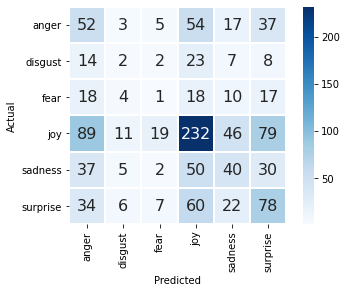

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       anger       0.22      0.32      0.26       168
     disgust       0.00      0.00      0.00        56
        fear       0.00      0.00      0.00        68
         joy       0.53      0.61      0.56       476
     sadness       0.35      0.21      0.27       164
    surprise       0.37      0.43      0.40       207

    accuracy                           0.41      1139
   macro avg       0.24      0.26      0.25      1139
weighted avg       0.37      0.41      0.38      1139



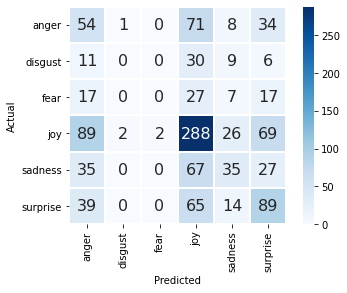

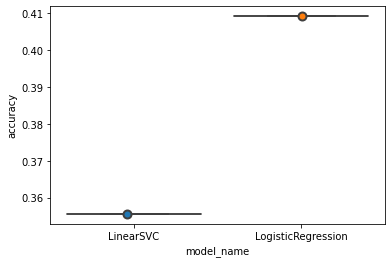

In [49]:
models = [
    LinearSVC(),
    LogisticRegression(random_state=0),
]
#CV = 5
#cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
pipelines=[]
for model in models:
  # define transform
  vectorizer = ColumnTransformer(vectorizers)
  # define pipeline
  pipeline = Pipeline(steps=[('t', vectorizer), ('m',model)])
  # fit the pipeline on the transformed data
  pipeline.fit(X_train, y_train)
  pipelines.append(pipeline)
  # make predictions
  y_pred= pipeline.predict(X_test)
  model_name = model.__class__.__name__
  #accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  accuracy = accuracy_score(y_test, y_pred)
  print(classification_report(y_test, y_pred))
  cf_matrix = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt = 'g', square=2, linewidth=1.)
  plt.show()

  entries.append((model_name, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
import joblib
for model,name in zip(pipelines,['SVM','LinearRegression']):
  model_dir = "/content/drive/MyDrive/models/"
  filename = model_dir + f"{name}.pkl"
  joblib.dump(model, filename)
  #pickle.dump(model, open(filename, 'wb'))

In [ ]:
import joblib
pipelines={}
for name in ['SVM','LinearRegression']:
  model_dir = "/content/drive/MyDrive/models/"
  filename = model_dir + f"{name}.pkl"
  # load the model from disk#
  #loaded_model = pickle.load(open(filename, 'rb'))
  loaded_model = joblib.load(filename)
  pipelines[name]=loaded_model

AttributeError: ignored

In [ ]:
utterance_1='was'
utterance_2='Mein Hund ist gestorben'
utterance_3=''
utterance_4=''
data = [{'utterance-1': utterance_1, 'utterance-2': utterance_2, 'utterance-3':utterance_3, 'utterance-4':utterance_4}]  
df = pd.DataFrame(data) 
pipelines["LinearRegression"].predict(df)[0]

'sadness'

In [ ]:
input=['Mein Hund ist gestorben','was?'][-4:]

In [ ]:
if len(input) < 4:
  input= ([''] * (4-len(input))) + input 

In [ ]:
input

['', '', 'Mein Hund ist gestorben', 'was?']

In [ ]:
[{f"utterance-{i+1}":input[-(1+i)]for i in range(4)}]

[{'utterance-1': 'was?',
  'utterance-2': 'Mein Hund ist gestorben',
  'utterance-3': '',
  'utterance-4': ''}]

In [ ]:
input[-1]

'was?'

In [ ]:
!pip show scikit-learn


Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, numpy, joblib
Required-by: yellowbrick, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn
